# Import module

In [1]:
__author__ = 'Zhanwei Liu'

import pandas as pd
import numpy as np
from scipy.stats import norm

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import  mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import ccf

from minepy import MINE

# Custom module
# from imp import reload
# reload(MyPrepaData)
from MyEvalCriteria import mae,rmse,corr,KGE,ia,BHV
import MyPrepaData

# Plot setting
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.sans-serif'] = 'Times New Roman'

# Preparation data

In [2]:
# 2011-2014 训练集；2015-2016 验证集；2017-2018 测试集。
data = pd.read_csv('2011-2018再分析和流量数据.csv',index_col=0)
data_train,data_test = data[:'20151231'],data['20151231':]

In [3]:
# Calc MIC
mine = MINE(alpha=0.6, c=15,est='mic_approx')
def mic(a,b):
    mine.compute_score(a,b)
    return mine.mic()

In [4]:
data_train.Q

2011-01-01    420
2011-01-02    415
2011-01-03    435
2011-01-04    415
2011-01-05    433
             ... 
2015-12-27    411
2015-12-28    284
2015-12-29    356
2015-12-30    292
2015-12-31    332
Name: Q, Length: 1826, dtype: int64

# Determining the lag of runoff and rainfall

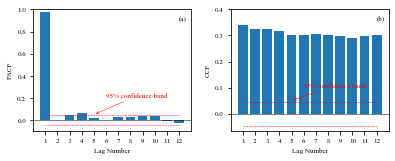

In [16]:
def mypacf(x, nlags=40, method='ols-unbiased', alpha=None):
    Qpacf = pacf(x=x, nlags=nlags, method=method, alpha=alpha)
    if alpha is not None:
        '''
        Calculation method of confidence interval：
        varacf = 1. / len(x)  # the length of series
        # ppf: Percent point function (inverse of cumulative distribution function(cdf))
        interval = stats.norm.ppf(1. - alpha / 2.) * np.sqrt(varacf) (while alpha=0.05, ≈ 1.96/√N)
        
        ref1: https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm
        ref2: https://www.statsmodels.org/stable/_modules/statsmodels/tsa/stattools.html#pacf
        '''
        interval = abs((Qpacf[1][:,0]- Qpacf[0])[1])
        return Qpacf[0],[interval for i in range(nlags+1)],[-interval for i in range(nlags+1)]
    else:
        return Qpacf[0]
def myccf(x, y, nlags=50,unbiased=True, alpha=None):
    cc = ccf(x=x,y=y,unbiased=True)
    if alpha is not None:
        varccf = 1. / len(x)
        interval = norm.ppf(1. - alpha / 2.) * np.sqrt(varccf)
        return cc[:nlags+1],[-varccf + interval for i in range(nlags+1)],[-varccf - interval for i in range(nlags+1)]
    else:
        return cc[:nlags]

def myplot_pacf(x, nlags=40, method='ywunbiased', alpha=None):
    if alpha is not None:
        Qpacf,up,bottom = mypacf(x=x, nlags=nlags, method=method, alpha=alpha)
        plt.plot(Qpacf)
        plt.plot(up)
        plt.plot(bottom)
    else:
        Qpacf = mypacf(x=x, nlags=nlags, method=method, alpha=alpha)
        plt.plot(Qpacf)

def myplot_ccf(x, y, nlags=50,unbiased=True, alpha=None):
    if alpha is not None:
        Qccf,up,bottom = myccf(x=x,y=y,nlags=nlags,unbiased=unbiased,alpha=alpha)
        plt.plot(Qccf)
        plt.plot(up)
        plt.plot(bottom)
    else:
        Qccf = myccf(x=x,y=y,nlags=nlags,unbiased=unbiased,alpha=alpha)
        plt.plot(Qccf)
Qpacf,up,bottom = mypacf(x=data_train.Q.values,nlags=12,alpha=0.05)
Qccf,upccf,bottomccf = myccf(x=data_train.real_p.values,y=data_train.Q.values,alpha=0.05,nlags=12)
'''
Plot Partial autocorrelation function（PACF）and Cross correlation function（CCF）
'''
fig = plt.figure(figsize=(5.51,2.25))
rcParams.update({'font.size': 7})
plt.subplot(121)
plt.bar(range(1,len(list(Qpacf))),list(Qpacf)[1:])
plt.plot(range(1,len(up)),up[1:],ls='--',c='r',lw=0.5)
plt.plot(range(1,len(up)),bottom[1:],ls='--',c='r',lw=0.5)
plt.hlines(y=0,xmin=-1,xmax=100,lw=0.5)
plt.xlim(0,13)
plt.xticks(range(1,13,1))
plt.xlabel('Lag Number')
plt.ylabel('PACF')
plt.ylim(top=1)
plt.yticks(np.linspace(0,1,6))
plt.annotate("95% confidence band",xy=(5,0.05),xytext=(6,0.2),color="r",
arrowprops=dict(arrowstyle="->",connectionstyle="arc3",color="r",linewidth=0.5))
plt.text(s='(a)',x=12,y=0.9)

plt.subplot(122)
plt.bar(range(1,len(list(Qccf))),list(Qccf)[1:])
plt.plot(range(1,len(upccf)),upccf[1:],ls='--',c='r',lw=0.5)
plt.plot(range(1,len(upccf)),bottomccf[1:],ls='--',c='r',lw=0.5)
plt.hlines(y=0,xmin=-1,xmax=100,lw=0.5)
plt.xlim(0,13)
plt.xticks(range(1,13,1))
plt.yticks(np.linspace(0,0.4,5),['%.1f'%i for i in np.linspace(0,0.4,5)])
plt.annotate("95% confidence band",xy=(5,0.05),xytext=(6,0.1),color="r",
arrowprops=dict(arrowstyle="->",connectionstyle="arc3",color="r",linewidth=0.5))
plt.xlabel('Lag Number')
plt.ylabel('CCF')
fig.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.text(s='(b)',x=12,y=0.36)
plt.savefig('PACF-CCF.tif',dpi=300,bbox_inches='tight',pad_inches=0.05)
print(end='')

E:\software\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


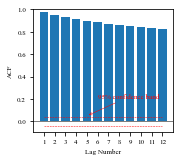

In [27]:
def myacf(x, nlags=40, method='ywunbiased', alpha=None):
    Qacf = acf(x=x, nlags=nlags, alpha=alpha)
    if alpha is not None:
        '''
        Calculation method of confidence interval：
        varacf = 1. / len(x)  # the length of series
        # ppf: Percent point function (inverse of cumulative distribution function(cdf))
        interval = stats.norm.ppf(1. - alpha / 2.) * np.sqrt(varacf) (while alpha=0.05, ≈ 1.96/√N)
        
        ref1: https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm
        ref2: https://www.statsmodels.org/stable/_modules/statsmodels/tsa/stattools.html#pacf
        '''
        interval = abs((Qacf[1][:,0]- Qacf[0])[1])
        return Qacf[0],[interval for i in range(nlags+1)],[-interval for i in range(nlags+1)]
    else:
        return Qacf[0]
Qacf,up,bottom = myacf(x=data_train.Q.values,nlags=12,alpha=0.05)
fig = plt.figure(figsize=(2.51,2.25))
rcParams.update({'font.size': 7})
plt.bar(range(1,len(list(Qacf))),list(Qacf)[1:])
plt.plot(range(1,len(up)),up[1:],ls='--',c='r',lw=0.5)
plt.plot(range(1,len(up)),bottom[1:],ls='--',c='r',lw=0.5)
plt.hlines(y=0,xmin=-1,xmax=100,lw=0.5)
plt.xlim(0,13)
plt.xticks(range(1,13,1))
plt.xlabel('Lag Number')
plt.ylabel('ACF')
plt.ylim(top=1)
plt.yticks(np.linspace(0,1,6))
plt.annotate("95% confidence band",xy=(5,0.05),xytext=(6,0.2),color="r",
arrowprops=dict(arrowstyle="->",connectionstyle="arc3",color="r",linewidth=0.5))
plt.savefig('ACF.tif',dpi=300,bbox_inches='tight',pad_inches=0.05)
# plt.annotate("95% confidence band",xy=(5,0.05),xytext=(6,0.2),color="r",
# arrowprops=dict(arrowstyle="->",connectionstyle="arc3",color="r",linewidth=0.5))

<font size=4 face="宋体">使用GBRT模型选择径流的滞后项与降雨的滞后项，首选选择一组默认参数，然后对各组特征进行计算选择误差较小的一组特征作为输入特征。2011-2014年为训练集，2015-2016年为验证集。根据PACF和CCF的分析，选择径流滞后1，4阶必选，降雨滞后1，2，3...20阶段备选,共21组备选输入结构:</font>
- 1.$Q_{t-1}$, $Q_{t-4}$
- 2.$Q_{t-1}$, $Q_{t-4}$, $R_{t-1}$
- 3.$Q_{t-1}$, $Q_{t-4}$, $R_{t-1}$, $R_{t-2}$  
- ...  
- 12.$Q_{t-1}$, $Q_{t-4}$, $R_{t-1}$, $R_{t-2}$, ..., $R_{t-11}$
- 13.$Q_{t-1}$, $Q_{t-4}$, $R_{t-1}$, $R_{t-2}$, ..., $R_{t-12}$  
<font size=4 face="宋体">默认参数：</font>
    loss='ls',
    learning_rate=0.1,
    n_estimators=100,
    subsample=1.0,
    criterion='friedman_mse',
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    init=None,
    random_state=None,
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    presort='auto',
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,

In [13]:
# micQ1 = pd.read_excel('result.xls',index_col=1,header=None)
# reanalysis = micQ1.index
reanalysis = ['stl3', 'd2m', 'tcwv', 'tcw', 'stl2', 'mn2t', 'tsn', 'stl4', 'stl1',
       'ro', 'swvl1', 'swvl2', 'swvl3', 't2m', 'swvl4', 'mx2t', 'sf', 'cp',
       'tp', 'rsn', 'lsp', 'sd', 'smlt', 'istl1', 'istl3', 'istl2']

预见期1:  ; 最优降雨滞后：6 ; 最优再分析滞后：8
Wall time: 46.4 s


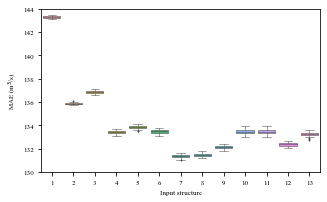

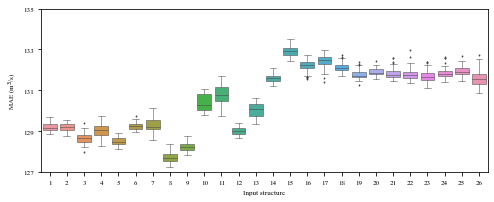

In [14]:
%%time
'''
针对每个预见期寻找最优的输入。
'''
rcParams.update({'font.size': 7})
Rlag = 13
itera = 50
model = GradientBoostingRegressor()
for leadtime in [1]:
    df = pd.DataFrame(columns=['input structure','mae'])
    for i in range(1,Rlag+1):
        X, y =  MyPrepaData.Preparation(data=data_train,Qlag=[1,4],Rlag=range(1,i),isreanalysis=False,leadtime=leadtime)
        length = X.shape[0]
        tscv =  iter([(np.arange(length-731, dtype=int),np.arange(length-731,length, dtype=int)) for i in range(itera)])
        score = cross_validate(model,X,y,cv=tscv,scoring=make_scorer(mae,greater_is_better=False),n_jobs=-1, verbose=0)
        df = df.append([{'input structure':i,'mae':-_} for _ in score['test_score']],ignore_index=True)

    df2 = pd.DataFrame(df.set_index(['input structure']).values.reshape(Rlag,itera)).median(axis=1)
    opt_Rlag = df2.idxmin()

    plt.figure(figsize=(5,3))
    plt.subplot(111)
    ax = sns.boxplot(x="input structure", y="mae", data=df,linewidth=0.5,fliersize=1)
    plt.xticks(range(0,13),range(1,14))
    plt.ylim(130,144)
    plt.yticks(range(130,145,2))
    plt.ylabel('MAE (m$^3$/s)')
    plt.xlabel('Input structure')
    plt.savefig('inputrainfall%d.tif'%leadtime,dpi=500,bbox_inches='tight')

    Relag = len(reanalysis)
    dfmic = pd.DataFrame(columns=['input structure','mae'])
    for i in range(1,Relag+1):
        X,y = MyPrepaData.Preparation(data=data_train,Qlag=[1,4],Rlag=range(1,opt_Rlag+1),
                          reanalysis=reanalysis[:i],isreanalysis=True,leadtime=leadtime)
        length = X.shape[0]
        tscv =  iter([(np.arange(length-731, dtype=int),np.arange(length-731,length, dtype=int)) for i in range(itera)])
        score = cross_validate(model,X,y,cv=tscv,scoring=make_scorer(mae,greater_is_better=False),n_jobs=-1, verbose=0)
        dfmic = dfmic.append([{'input structure':i,'mae':-_} for _ in score['test_score']],ignore_index=True)
    dfmic2 = pd.DataFrame(dfmic.set_index(['input structure']).values.reshape(Relag,itera)).median(axis=1)
    opt_Relag = dfmic2.idxmin()+1

    plt.figure(figsize=(8,3))
    ax = sns.boxplot(x="input structure", y="mae", data=dfmic,linewidth=0.5,fliersize=1)
    plt.xticks(range(0,26,1),range(1,27,1))
    plt.ylim(127,135)
    plt.yticks(range(127,136,2))
    plt.ylabel('MAE (m$^3$/s)')
    plt.xlabel('Input structure')
    plt.savefig('inputreanalysis%d.tif'%leadtime,dpi=500,bbox_inches='tight')
    
    print('预见期%d: '%leadtime,'; 最优降雨滞后：%d'%opt_Rlag,'; 最优再分析滞后：%d'%opt_Relag)